In [80]:
%pip install --quiet --upgrade pip jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab pyarrow numpy scipy statsmodels

Note: you may need to restart the kernel to use updated packages.


In [81]:
import duckdb
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget
conn = duckdb.connect()
%sql conn --alias duckdb
pd.options.mode.copy_on_write = True

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [82]:
%config SqlMagic.autopandas = True
#%config SqlMagic.displaycon = False

In [83]:
%%sql
INSTALL sqlite;
LOAD sqlite;

Running query in 'duckdb'

,Success


In [84]:
%%sql
ATTACH '399722.db' AS expdb (TYPE SQLITE) ;
USE expdb.main;

Running query in 'duckdb'

,Success


In [85]:
# set some matplotlib defaults
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator, MicrosecondLocator
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
plt.rcParams['svg.fonttype'] = 'none'
# Set the global locator and formatter
plt.rcParams['date.autoformatter.microsecond'] = '%S.%f'  # Set the global format for microsecond level
plt.rcParams['date.autoformatter.second'] = '%H:%M:%S'  # Set the global format for second level
plt.rcParams['date.autoformatter.minute'] = '%H:%M'  # Set the global format for minute level
plt.rcParams['date.autoformatter.hour'] = '%Y-%m-%d %H:%M'  # Set the global format for hour level
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d %H:%M'  # Set the global format for day level
plt.rcParams['date.autoformatter.month'] = '%Y-%m-%d %H:%M'  # Set the global format for month level
plt.rcParams['date.autoformatter.year'] = '%Y-%m-%d %H:%M'  # Set the global format for year level


In [86]:
%sql SHOW;

Running query in 'duckdb'

,database,schema,name,column_names,column_types,temporary
0,expdb,main,Join_Message,"[join_message_id, app_received_at]","[BIGINT, TIMESTAMP]",False
1,expdb,main,Message,"[message_id, related_node, network_received_at]","[BIGINT, VARCHAR, TIMESTAMP]",False
2,expdb,main,Node,"[node_deveui, node_appeui, node_appkey, board_...","[VARCHAR, VARCHAR, VARCHAR, VARCHAR, VARCHAR, ...",False
3,expdb,main,Power_Consumption,"[power_consumption_id, node_id, timestamp, cur...","[BIGINT, VARCHAR, TIMESTAMP, DOUBLE, DOUBLE, D...",False
4,expdb,main,Radio,"[radio_id, timestamp, node_id, channel, rssi]","[BIGINT, TIMESTAMP, VARCHAR, BIGINT, BIGINT]",False
5,expdb,main,Site,[name],[VARCHAR],False
6,expdb,main,Trace,"[trace_id, node_id, timestamp, message]","[BIGINT, VARCHAR, TIMESTAMP, VARCHAR]",False
7,expdb,main,Uplink_Message,"[uplink_message_id, through_gateway, gateway_r...","[BIGINT, VARCHAR, TIMESTAMP, TIMESTAMP, BIGINT...",False
8,expdb,main,sqlite_sequence,"[name, seq]","[BLOB, BLOB]",False


In [87]:
hej = %sql select message from expdb.Trace WHERE message LIKE 'TIMINGS>%'

Running query in 'duckdb'

In [88]:
hej["message"][0]

'TIMINGS> Loop: 0, Sync: 806 ms, Load: 21 ms, deserialize: 3 ms, sensor init: 25 ms, net init: 8425 ms, Collect: 77 ms, Exec: 33 ms, Send: 10022 ms, save config: 603 ms, Sleep: 4 s\n'

In [89]:
%sql nodes =<< select distinct * from expdb.Node

Running query in 'duckdb'

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA63,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
1,70B3D57ED005EA70,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
2,70B3D57ED005EA72,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
3,70B3D57ED005EA66,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
4,70B3D57ED005EA67,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
5,70B3D57ED005EA74,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
6,70B3D57ED005EA62,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
7,70B3D57ED005EA65,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
8,70B3D57ED005EA78,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
9,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0


In [90]:
%%sql
DESCRIBE expdb.Trace

Running query in 'duckdb'

,column_name,column_type,null,key,default,extra


In [91]:
%%sql
select * from expdb.Power_Consumption WHERE node_id= '70B3D57ED005EA60' limit 5

Running query in 'duckdb'

,power_consumption_id,node_id,timestamp,current,voltage,power
0,6412953,70B3D57ED005EA60,2024-06-03 13:26:59.753113,0.057922,4.96375,0.287532
1,6412954,70B3D57ED005EA60,2024-06-03 13:26:59.754242,0.058019,4.96625,0.288143
2,6412955,70B3D57ED005EA60,2024-06-03 13:26:59.755371,0.057751,4.96250,0.286922
3,6412956,70B3D57ED005EA60,2024-06-03 13:26:59.756500,0.057897,4.96250,0.287532
4,6412957,70B3D57ED005EA60,2024-06-03 13:26:59.757599,0.058263,4.96625,0.289363


In [92]:

timestamps= %sql select timestamp from expdb.Power_Consumption 
timestamps

Running query in 'duckdb'

,timestamp
0,2024-06-03 13:26:59.745843
1,2024-06-03 13:26:59.746972
2,2024-06-03 13:26:59.748101
3,2024-06-03 13:26:59.749230
4,2024-06-03 13:26:59.750359
...,...
21451972,2024-06-03 13:47:06.009651
21451973,2024-06-03 13:47:06.010780
21451974,2024-06-03 13:47:06.011939
21451975,2024-06-03 13:47:06.013099


In [93]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from expdb.Power_Consumption group by node_id

Running query in 'duckdb'

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005EA65,1061384,2024-06-03 13:26:59.745843,2024-06-03 13:47:06.021678
1,70B3D57ED005EA78,1062909,2024-06-03 13:27:00.039667,2024-06-03 13:47:06.015244
2,70B3D57ED005EA76,1065262,2024-06-03 13:26:59.977580,2024-06-03 13:47:06.021600
3,70B3D57ED005EA74,1093900,2024-06-03 13:26:59.863171,2024-06-03 13:47:06.021527
4,70B3D57ED005EA75,1087984,2024-06-03 13:26:59.784680,2024-06-03 13:47:06.014958
5,70B3D57ED005EA61,1077948,2024-06-03 13:26:59.762444,2024-06-03 13:47:06.024426
6,70B3D57ED005EA70,1059941,2024-06-03 13:26:59.761741,2024-06-03 13:47:06.016857
7,70B3D57ED005EA62,1049781,2024-06-03 13:26:59.869664,2024-06-03 13:47:06.014228
8,70B3D57ED005EA68,1068169,2024-06-03 13:26:59.848930,2024-06-03 13:47:06.028066
9,70B3D57ED005EA67,1073213,2024-06-03 13:26:59.758025,2024-06-03 13:47:06.027514


In [94]:
deveui = "70B3D57ED005EA59"

power_consumption= %sql select timestamp,power,current,voltage,node_id from expdb.Power_Consumption
power_consumption = power_consumption.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power_consumption.groupby("node_id")
groups.groups.keys()

Running query in 'duckdb'

dict_keys(['70B3D57ED005EA59', '70B3D57ED005EA60', '70B3D57ED005EA61', '70B3D57ED005EA62', '70B3D57ED005EA63', '70B3D57ED005EA64', '70B3D57ED005EA65', '70B3D57ED005EA66', '70B3D57ED005EA67', '70B3D57ED005EA68', '70B3D57ED005EA69', '70B3D57ED005EA70', '70B3D57ED005EA71', '70B3D57ED005EA72', '70B3D57ED005EA73', '70B3D57ED005EA74', '70B3D57ED005EA75', '70B3D57ED005EA76', '70B3D57ED005EA77', '70B3D57ED005EA78'])

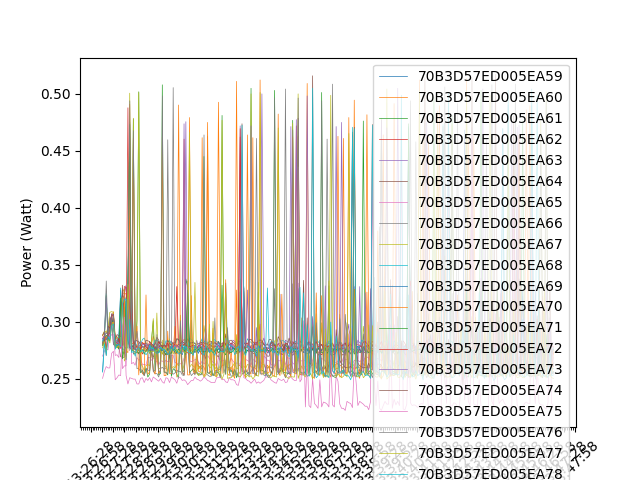

In [95]:
plt.figure()

for node_id, group in groups:
    idxs = np.linspace(0,len(group), 250, endpoint=False, dtype=int)

    subset = group["power"].iloc[idxs]
    plt.plot(subset.index, subset, label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.xticks(rotation=45)
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))  # Set the major locator to display labels every 30 seconds
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))  # Set the minor locator to display labels at millisecond level
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S')) 
#plt.gca().xaxis.set_minor_formatter(DateFormatter('%S.%f'))  
plt.legend()
plt.show()

In [96]:
groups["power"].get_group(deveui)

timestamp
2024-06-03 13:26:59.876548    0.256398
2024-06-03 13:26:59.877677    0.282038
2024-06-03 13:26:59.878775    0.281427
2024-06-03 13:26:59.879874    0.280817
2024-06-03 13:26:59.881003    0.281427
                                ...   
2024-06-03 13:47:06.023156    0.330876
2024-06-03 13:47:06.024254    0.332096
2024-06-03 13:47:06.025383    0.330876
2024-06-03 13:47:06.026482    0.335759
2024-06-03 13:47:06.027580    0.311340
Name: power, Length: 1086843, dtype: float64

## finding sync signals

In [97]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

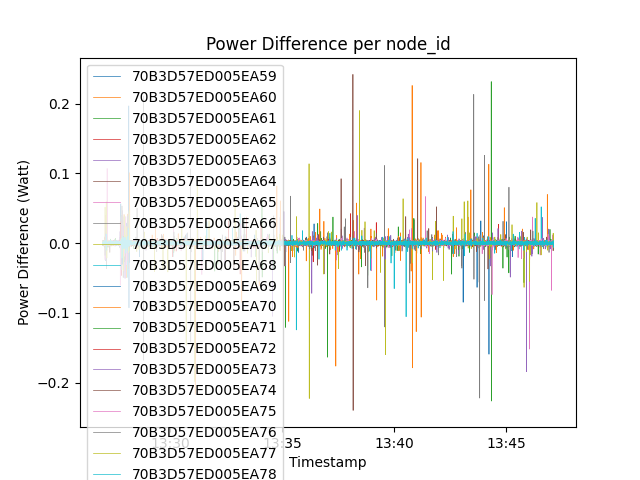

In [98]:
#diff of each group
power_consumption['power_diff'] = groups["power"].diff()

# single node
power_single = power_consumption[(power_consumption["node_id"] ==deveui)]
plt.figure()
for node_id, group in power_consumption.groupby("node_id"):
    idxs = np.linspace(0,len(group), 10000, endpoint=False, dtype=int) # there are comparatively few but big jumps, so hard to see when just taking "random" indexes
    subset = group["power_diff"].iloc[idxs]
    plt.plot(subset.index, subset, label=node_id, linewidth=0.5)
plt.title("Power Difference per node_id")
plt.xlabel("Timestamp")
plt.ylabel("Power Difference (Watt)")
plt.legend()
plt.show()

In [99]:
rising_edge = power_consumption[power_consumption["power_diff"] > 0.1].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_consumption["power_diff"] < -0.1].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2024-06-03 13:27:12.207770,0.296079,0.061365,4.82875,70B3D57ED005EA75,0.106833,rising
2024-06-03 13:28:07.021923,0.396196,0.080680,4.91125,70B3D57ED005EA63,0.112937,rising
2024-06-03 13:28:07.023052,0.499976,0.101973,4.90375,70B3D57ED005EA63,0.103780,rising
2024-06-03 13:28:07.222247,0.368725,0.075088,4.91250,70B3D57ED005EA63,-0.130030,falling
2024-06-03 13:28:07.384727,0.492650,0.102462,4.81000,70B3D57ED005EA62,0.156280,rising


In [100]:
# populate edges with next direction and timestamps to later filter out edges that are too close to each other.
# need the index as dedicated column for this to be possible as a groupby transformation
edges['timestamp'] = edges.index.copy()
edges['next_direction'] = edges.groupby('node_id')['direction'].shift(-1)
edges['next_timestamp'] = edges.groupby('node_id')['timestamp'].shift(-1)
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp
timestamp,,,,,,,,,
2024-06-03 13:27:12.207770,0.296079,0.061365,4.82875,70B3D57ED005EA75,0.106833,rising,2024-06-03 13:27:12.207770,rising,2024-06-03 13:28:11.847647
2024-06-03 13:28:07.021923,0.396196,0.080680,4.91125,70B3D57ED005EA63,0.112937,rising,2024-06-03 13:28:07.021923,rising,2024-06-03 13:28:07.023052
2024-06-03 13:28:07.023052,0.499976,0.101973,4.90375,70B3D57ED005EA63,0.103780,rising,2024-06-03 13:28:07.023052,falling,2024-06-03 13:28:07.222247
2024-06-03 13:28:07.222247,0.368725,0.075088,4.91250,70B3D57ED005EA63,-0.130030,falling,2024-06-03 13:28:07.222247,rising,2024-06-03 13:28:07.424860
2024-06-03 13:28:07.384727,0.492650,0.102462,4.81000,70B3D57ED005EA62,0.156280,rising,2024-06-03 13:28:07.384727,falling,2024-06-03 13:28:07.584655


In [101]:
# now to filter out edges that are too close to each other or too far apart. We add 10% tolerance

# filter out edges that are too close to each other or too far apart. We add 10% tolerance
edges = edges[(edges['direction'] == "rising") & (edges['next_direction'] == "falling") & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=BLINK_HIGH_MS + (BLINK_HIGH_MS/10)))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=BLINK_HIGH_MS - (BLINK_HIGH_MS/10))))]
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp
timestamp,,,,,,,,,
2024-06-03 13:28:07.023052,0.499976,0.101973,4.90375,70B3D57ED005EA63,0.103780,rising,2024-06-03 13:28:07.023052,falling,2024-06-03 13:28:07.222247
2024-06-03 13:28:07.384727,0.492650,0.102462,4.81000,70B3D57ED005EA62,0.156280,rising,2024-06-03 13:28:07.384727,falling,2024-06-03 13:28:07.584655
2024-06-03 13:28:07.424860,0.428551,0.087200,4.90875,70B3D57ED005EA63,0.145292,rising,2024-06-03 13:28:07.424860,falling,2024-06-03 13:28:07.625216
2024-06-03 13:28:07.786872,0.418173,0.086882,4.81000,70B3D57ED005EA62,0.143461,rising,2024-06-03 13:28:07.786872,falling,2024-06-03 13:28:07.987929
2024-06-03 13:28:08.190419,0.476168,0.097675,4.87625,70B3D57ED005EA72,0.194130,rising,2024-06-03 13:28:08.190419,falling,2024-06-03 13:28:08.390316


In [102]:
## add sync signal start and end times
edges.loc[:, 'sync_start'] = edges.index - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp,sync_start,sync_end
timestamp,,,,,,,,,,,
2024-06-03 13:28:07.023052,0.499976,0.101973,4.90375,70B3D57ED005EA63,0.103780,rising,2024-06-03 13:28:07.023052,falling,2024-06-03 13:28:07.222247,2024-06-03 13:28:06.923052,2024-06-03 13:28:07.322247
2024-06-03 13:28:07.384727,0.492650,0.102462,4.81000,70B3D57ED005EA62,0.156280,rising,2024-06-03 13:28:07.384727,falling,2024-06-03 13:28:07.584655,2024-06-03 13:28:07.284727,2024-06-03 13:28:07.684655
2024-06-03 13:28:07.424860,0.428551,0.087200,4.90875,70B3D57ED005EA63,0.145292,rising,2024-06-03 13:28:07.424860,falling,2024-06-03 13:28:07.625216,2024-06-03 13:28:07.324860,2024-06-03 13:28:07.725216
2024-06-03 13:28:07.786872,0.418173,0.086882,4.81000,70B3D57ED005EA62,0.143461,rising,2024-06-03 13:28:07.786872,falling,2024-06-03 13:28:07.987929,2024-06-03 13:28:07.686872,2024-06-03 13:28:08.087929
2024-06-03 13:28:08.190419,0.476168,0.097675,4.87625,70B3D57ED005EA72,0.194130,rising,2024-06-03 13:28:08.190419,falling,2024-06-03 13:28:08.390316,2024-06-03 13:28:08.090419,2024-06-03 13:28:08.490316


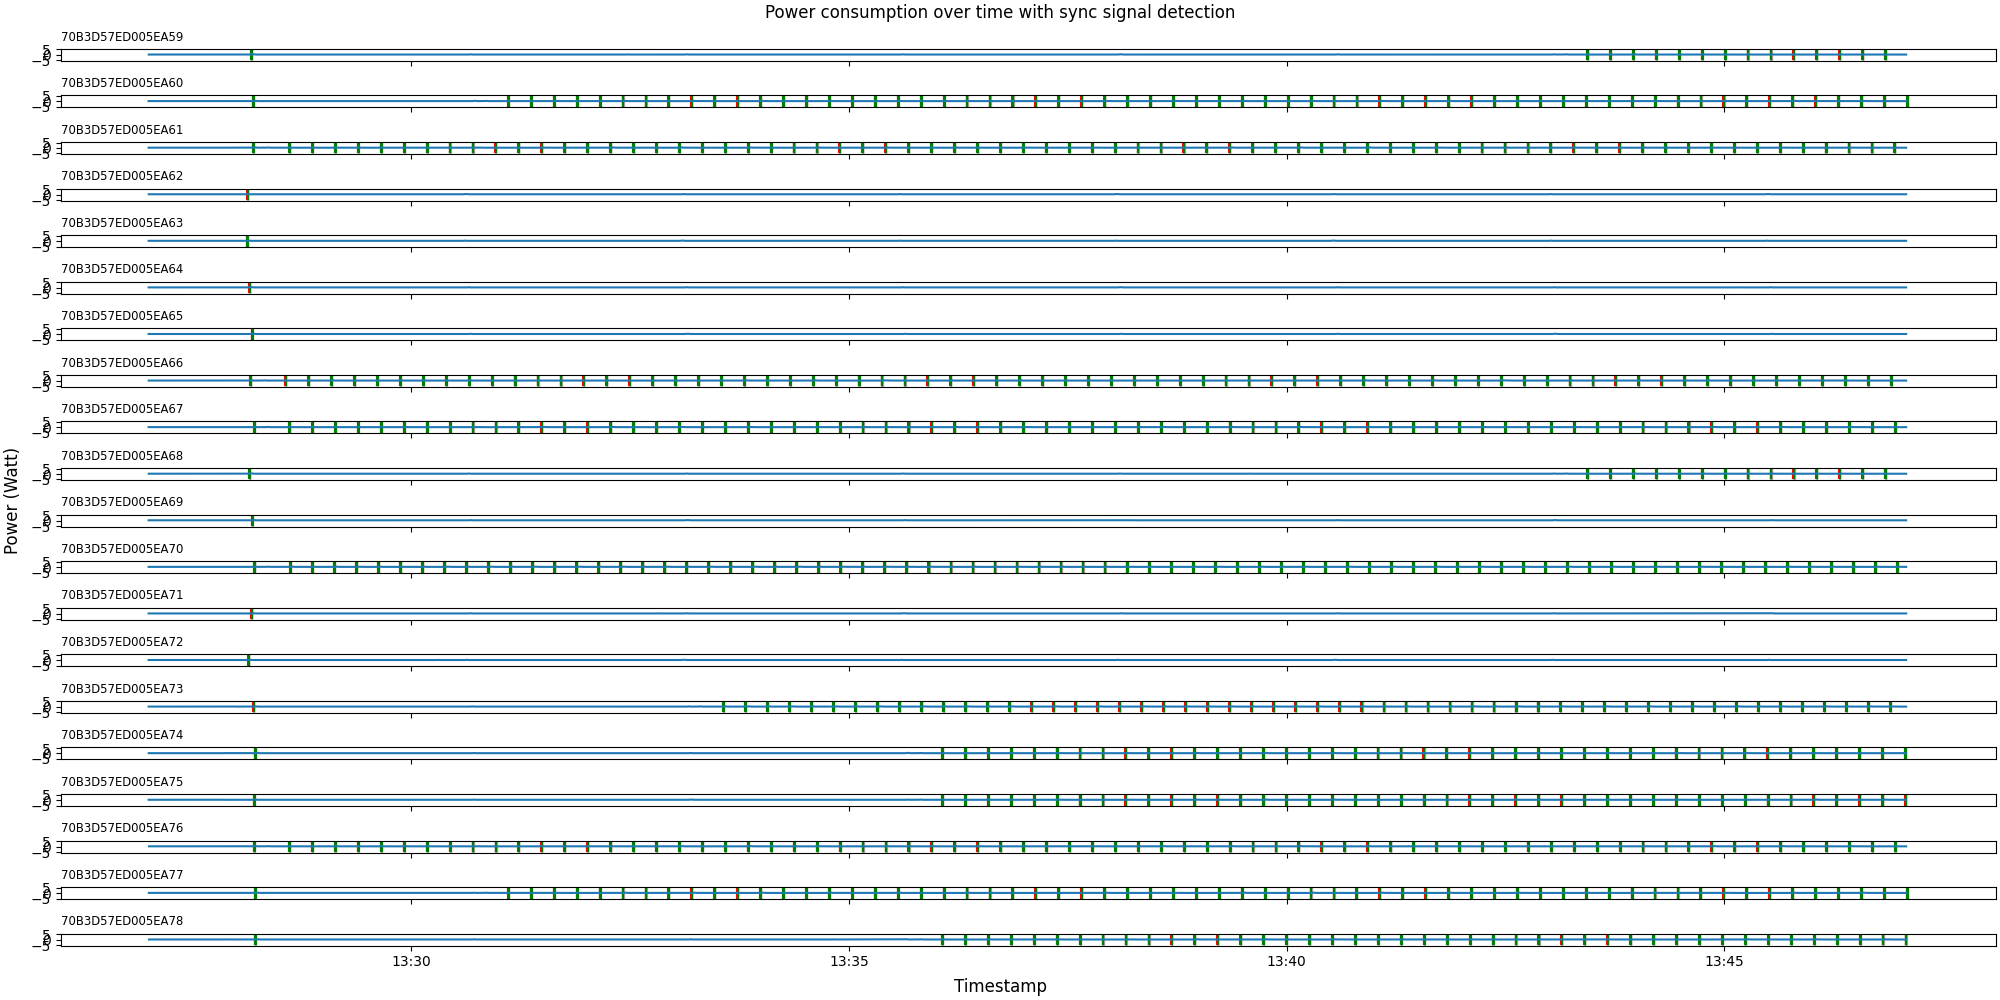

In [103]:
groups_by_node_id = power_consumption.groupby('node_id')
edges_by_node_id = edges.groupby('node_id')

fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, layout='constrained', figsize=(20, 10))
fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
fig.suptitle("Power consumption over time with sync signal detection")
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in edges_by_node_id.groups:
        edges_grouped = edges_by_node_id.get_group(node_id)
        ax.vlines(edges_grouped['timestamp'], ymin=-5, ymax=5, color='red')
        ax.vlines(edges_grouped['next_timestamp'], ymin=-5, ymax=5, color='green')
        for row in edges_by_node_id.get_group(node_id).itertuples():
            ax.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5)

    else:
        print(f"Node {node_id} has no edges")
    idxs = np.linspace(0, len(group), endpoint=False, num=1000, dtype=int)
    subset = group["power"].iloc[idxs]
    ax.plot(subset.index, subset, label=node_id)
    ax.set_title(node_id, fontsize='small', loc='left')
plt.show()

In [104]:
# every loop starts with 2 sync signals right after each other
# find all sync signals where the next start is very close to previous end
grouped = edges.groupby('node_id')
edges['next_sync_start'] = grouped['sync_start'].shift(-1)
edges['next_sync_end'] = grouped['sync_end'].shift(-1)
loops = edges[abs(edges['sync_end'] - edges['next_sync_start']) < pd.Timedelta(milliseconds=500)][['node_id', 'sync_start', 'next_sync_end']].copy()
loops.rename(columns={'sync_start': 'loop_signal_start', 'next_sync_end': 'loop_signal_end'}, inplace=True)
loops['loop_num'] = loops.groupby('node_id').cumcount()
loops[['node_id','loop_num']]


,node_id,loop_num
timestamp,,
2024-06-03 13:28:07.023052,70B3D57ED005EA63,0
2024-06-03 13:28:07.384727,70B3D57ED005EA62,0
2024-06-03 13:28:08.190419,70B3D57ED005EA72,0
2024-06-03 13:28:08.740145,70B3D57ED005EA68,0
2024-06-03 13:28:08.846228,70B3D57ED005EA64,0
...,...,...
2024-06-03 13:47:03.994876,70B3D57ED005EA74,43
2024-06-03 13:47:04.197816,70B3D57ED005EA75,43
2024-06-03 13:47:04.430162,70B3D57ED005EA78,43


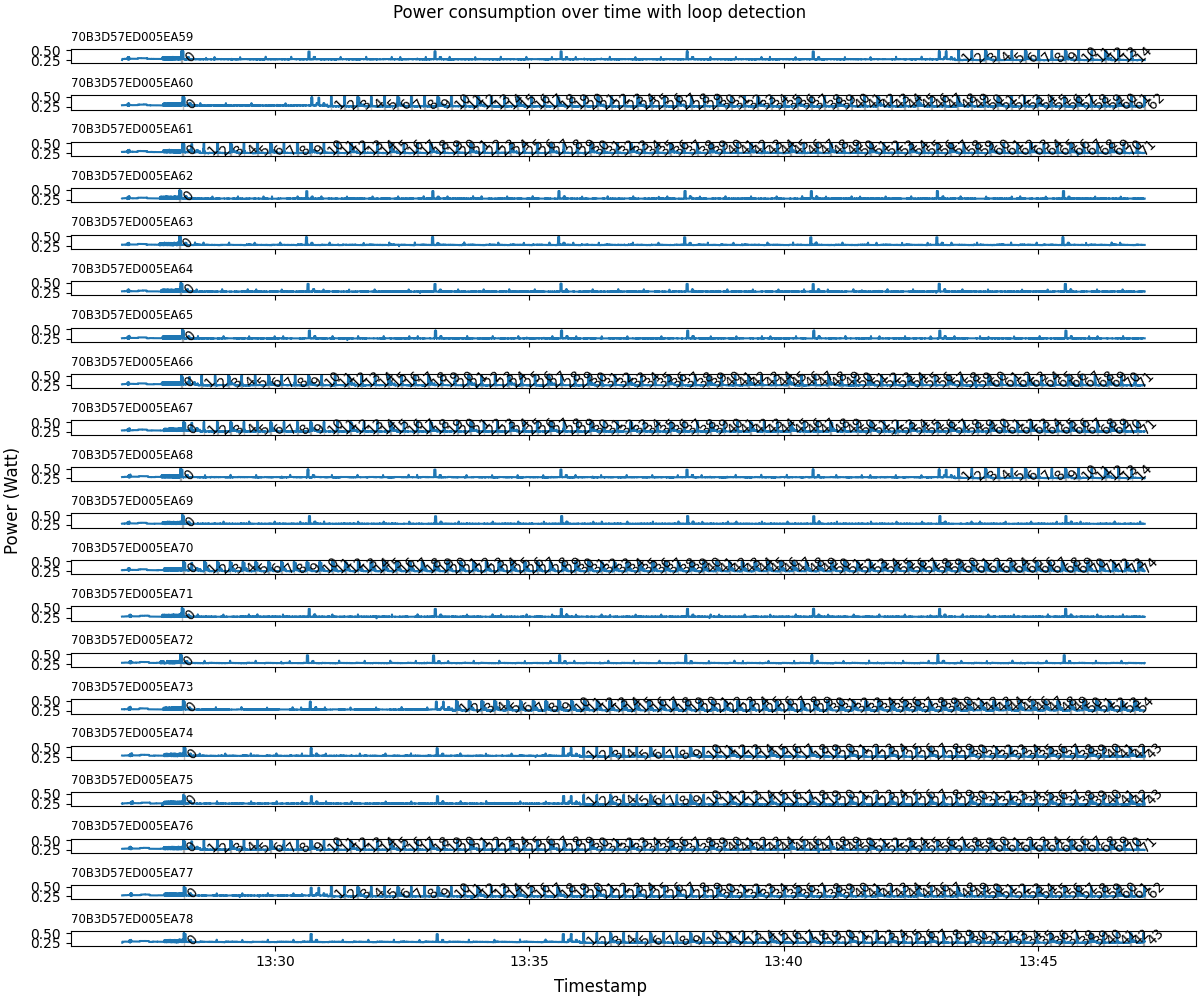

In [105]:

groups_by_node_id = power_consumption.groupby('node_id')
loops_by_node_id = loops.groupby('node_id')
fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, figsize=(12, 10), layout='constrained')

fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
fig.suptitle("Power consumption over time with loop detection")
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in loops_by_node_id.groups:
        loops_group = loops_by_node_id.get_group(node_id)
        for row in loops_group.itertuples():
            ax.axvspan(row.loop_signal_start, row.loop_signal_end, color='tab:gray', alpha=0.5, label="loop signal")
            ax.text(row.loop_signal_end, 0.2, f"{row.loop_num}", rotation=45)
    else:
        print(f"Node {node_id} has no loops")
    idxs = np.linspace(0, len(group), endpoint=False, num=10000, dtype=int)
    subset = group["power"].iloc[idxs]

    ax.plot(subset.index, subset,label=node_id)
    ax.set_title(node_id, fontsize='small', loc='left')

plt.show()

In [27]:
# 'TIMINGS> Loop: 0, Sync: 806 ms, Load: 40 ms, sensor init: 10 ms, env init: 0 ms, net init: 5216 ms, Collect: -1 ms, Exec: -1 ms, Send: 5119 ms, save config: 2646 ms, Sleep: 9 s\n'
query = """
SELECT 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: (-?[0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: (-?[0-9]+)',1) as sync_time_ms,
    regexp_extract(message, '.*Load: (-?[0-9]+)',1) as load_time_ms,
    regexp_extract(message, '.*deserialize: (-?[0-9]+)',1) as deserialize_time_ms,
    regexp_extract(message, '.*sensor init: (-?[0-9]+)',1) as sensor_init_time_ms,
    regexp_extract(message, '.*net init: (-?[0-9]+)',1) as net_init_time_ms,
    --regexp_extract(message, '.*Listen: (-?[0-9]+)',1) as listen_time_ms,
    regexp_extract(message, '.*Collect: (-?[0-9]+)',1) as collect_time_ms,
    regexp_extract(message, '.*Exec: (-?[0-9]+)',1) as exec_time_ms,
    regexp_extract(message, '.*Send: (-?[0-9]+)',1) as send_time_ms,
    regexp_extract(message, '.*save config: (-?[0-9]+)',1) as save_config_time_ms,
    regexp_extract(message, '.*Sleep: (-?[0-9]+)',1) as sleep_time_s
FROM expdb.Trace
WHERE message LIKE 'TIMINGS>%'
"""
timings = %sql {{query}}
timings['node_id'].unique()

Running query in 'duckdb'

array(['70B3D57ED005EA66', '70B3D57ED005EA61', '70B3D57ED005EA67',
       '70B3D57ED005EA76', '70B3D57ED005EA70', '70B3D57ED005EA60',
       '70B3D57ED005EA77', '70B3D57ED005EA73', '70B3D57ED005EA74',
       '70B3D57ED005EA75', '70B3D57ED005EA78', '70B3D57ED005EA68',
       '70B3D57ED005EA59'], dtype=object)

In [28]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'deserialize_time_ms', 'sensor_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']] = timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'deserialize_time_ms', 'sensor_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('loop_signal_start')
loops.head()

,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,deserialize_time_ms,sensor_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
loop_signal_start,,,,,,,,,,,,,,,
2024-06-03 13:28:08.640145,2024-06-03 13:28:08.740145,70B3D57ED005EA68,2024-06-03 13:28:09.443133,0,2024-06-03 13:43:21.811869,806,21,3,26,901602,77,33,10021,604,4
2024-06-03 13:28:09.238729,2024-06-03 13:28:09.338729,70B3D57ED005EA66,2024-06-03 13:28:10.041717,0,2024-06-03 13:28:29.275036,806,21,3,25,8425,77,33,10022,603,4
2024-06-03 13:28:09.849694,2024-06-03 13:28:09.949694,70B3D57ED005EA59,2024-06-03 13:28:10.653384,0,2024-06-03 13:43:21.813629,806,21,3,25,900375,77,33,10023,603,4
2024-06-03 13:28:11.016448,2024-06-03 13:28:11.116448,70B3D57ED005EA61,2024-06-03 13:28:11.819588,0,2024-06-03 13:28:31.844136,806,21,3,25,9401,77,33,9839,603,4
2024-06-03 13:28:11.176134,2024-06-03 13:28:11.276134,70B3D57ED005EA60,2024-06-03 13:28:11.979366,0,2024-06-03 13:31:01.901001,806,21,3,25,159121,76,33,10021,605,4


In [29]:

loops["start_time"] = loops.index
loops["sync_start"] = loops["start_time"]
loops["sync_end"] = loops["sync_start"] + pd.to_timedelta(loops["sync_time_ms"], unit="ms")
loops["load_start"] = loops["sync_end"]
loops["load_end"] = loops["load_start"] + pd.to_timedelta(loops["load_time_ms"], unit="ms")
loops["deserialize_start"] = loops["load_end"]
loops["deserialize_end"] = loops["deserialize_start"] + pd.to_timedelta(loops["deserialize_time_ms"], unit="ms")
loops["sensor_init_start"] = loops["deserialize_end"]
loops["sensor_init_end"] = loops["sensor_init_start"] + pd.to_timedelta(loops["sensor_init_time_ms"], unit="ms")
loops["net_init_start"] = loops["sensor_init_end"]
loops["net_init_end"] = loops["net_init_start"] + pd.to_timedelta(loops["net_init_time_ms"], unit="ms")
loops["collect_time_start"] = loops["net_init_end"]
loops["collect_time_end"] = loops["collect_time_start"] +pd.to_timedelta(loops["collect_time_ms"], unit="ms")
loops["exec_start"] = loops["collect_time_end"]
loops["exec_end"] = loops["exec_start"] + pd.to_timedelta(loops["exec_time_ms"], unit="ms")
loops["send_start"] = loops["exec_end"]
loops["send_end"] = loops["send_start"] +pd.to_timedelta(loops["send_time_ms"], unit="ms")
loops["save_config_start"] = loops["send_end"]
loops["save_config_end"] = loops["save_config_start"] + pd.to_timedelta(loops["save_config_time_ms"], unit="ms")
loops["sleep_start"] = loops["save_config_end"]
loops["sleep_end"] = loops["sleep_start"] + pd.to_timedelta(loops["sleep_time_s"], unit="s")

loops.replace(-1,0) # remove -1 values. They show up if the time measurement is not available



,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,deserialize_time_ms,sensor_init_time_ms,net_init_time_ms,...,collect_time_start,collect_time_end,exec_start,exec_end,send_start,send_end,save_config_start,save_config_end,sleep_start,sleep_end
loop_signal_start,,,,,,,,,,,,,,,,,,,,,
2024-06-03 13:28:08.640145,2024-06-03 13:28:08.740145,70B3D57ED005EA68,2024-06-03 13:28:09.443133,0,2024-06-03 13:43:21.811869,806,21,3,26,901602,...,2024-06-03 13:43:11.098145,2024-06-03 13:43:11.175145,2024-06-03 13:43:11.175145,2024-06-03 13:43:11.208145,2024-06-03 13:43:11.208145,2024-06-03 13:43:21.229145,2024-06-03 13:43:21.229145,2024-06-03 13:43:21.833145,2024-06-03 13:43:21.833145,2024-06-03 13:43:25.833145
2024-06-03 13:28:09.238729,2024-06-03 13:28:09.338729,70B3D57ED005EA66,2024-06-03 13:28:10.041717,0,2024-06-03 13:28:29.275036,806,21,3,25,8425,...,2024-06-03 13:28:18.518729,2024-06-03 13:28:18.595729,2024-06-03 13:28:18.595729,2024-06-03 13:28:18.628729,2024-06-03 13:28:18.628729,2024-06-03 13:28:28.650729,2024-06-03 13:28:28.650729,2024-06-03 13:28:29.253729,2024-06-03 13:28:29.253729,2024-06-03 13:28:33.253729
2024-06-03 13:28:09.849694,2024-06-03 13:28:09.949694,70B3D57ED005EA59,2024-06-03 13:28:10.653384,0,2024-06-03 13:43:21.813629,806,21,3,25,900375,...,2024-06-03 13:43:11.079694,2024-06-03 13:43:11.156694,2024-06-03 13:43:11.156694,2024-06-03 13:43:11.189694,2024-06-03 13:43:11.189694,2024-06-03 13:43:21.212694,2024-06-03 13:43:21.212694,2024-06-03 13:43:21.815694,2024-06-03 13:43:21.815694,2024-06-03 13:43:25.815694
2024-06-03 13:28:11.016448,2024-06-03 13:28:11.116448,70B3D57ED005EA61,2024-06-03 13:28:11.819588,0,2024-06-03 13:28:31.844136,806,21,3,25,9401,...,2024-06-03 13:28:21.272448,2024-06-03 13:28:21.349448,2024-06-03 13:28:21.349448,2024-06-03 13:28:21.382448,2024-06-03 13:28:21.382448,2024-06-03 13:28:31.221448,2024-06-03 13:28:31.221448,2024-06-03 13:28:31.824448,2024-06-03 13:28:31.824448,2024-06-03 13:28:35.824448
2024-06-03 13:28:11.176134,2024-06-03 13:28:11.276134,70B3D57ED005EA60,2024-06-03 13:28:11.979366,0,2024-06-03 13:31:01.901001,806,21,3,25,159121,...,2024-06-03 13:30:51.152134,2024-06-03 13:30:51.228134,2024-06-03 13:30:51.228134,2024-06-03 13:30:51.261134,2024-06-03 13:30:51.261134,2024-06-03 13:31:01.282134,2024-06-03 13:31:01.282134,2024-06-03 13:31:01.887134,2024-06-03 13:31:01.887134,2024-06-03 13:31:05.887134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03 13:46:57.044150,2024-06-03 13:46:57.144150,70B3D57ED005EA76,2024-06-03 13:46:57.846497,71,2024-06-03 13:46:58.621227,806,21,3,25,54,...,2024-06-03 13:46:57.953150,2024-06-03 13:46:58.030150,2024-06-03 13:46:58.030150,2024-06-03 13:46:58.063150,2024-06-03 13:46:58.063150,2024-06-03 13:46:58.065150,2024-06-03 13:46:58.065150,2024-06-03 13:46:58.604150,2024-06-03 13:46:58.604150,2024-06-03 13:47:12.604150
2024-06-03 13:46:57.049026,2024-06-03 13:46:57.149026,70B3D57ED005EA67,2024-06-03 13:46:57.852624,71,2024-06-03 13:46:58.626075,806,21,3,25,54,...,2024-06-03 13:46:57.958026,2024-06-03 13:46:58.035026,2024-06-03 13:46:58.035026,2024-06-03 13:46:58.068026,2024-06-03 13:46:58.068026,2024-06-03 13:46:58.070026,2024-06-03 13:46:58.070026,2024-06-03 13:46:58.609026,2024-06-03 13:46:58.609026,2024-06-03 13:47:12.609026
2024-06-03 13:46:58.594921,2024-06-03 13:46:58.694921,70B3D57ED005EA70,2024-06-03 13:46:59.396933,74,2024-06-03 13:47:04.548238,806,22,80,25,54,...,2024-06-03 13:46:59.581921,2024-06-03 13:46:59.804921,2024-06-03 13:46:59.804921,2024-06-03 13:46:59.958921,2024-06-03 13:46:59.958921,2024-06-03 13:47:03.993921,2024-06-03 13:47:03.993921,2024-06-03 13:47:04.528921,2024-06-03 13:47:04.528921,2024-06-03 13:47:13.528921


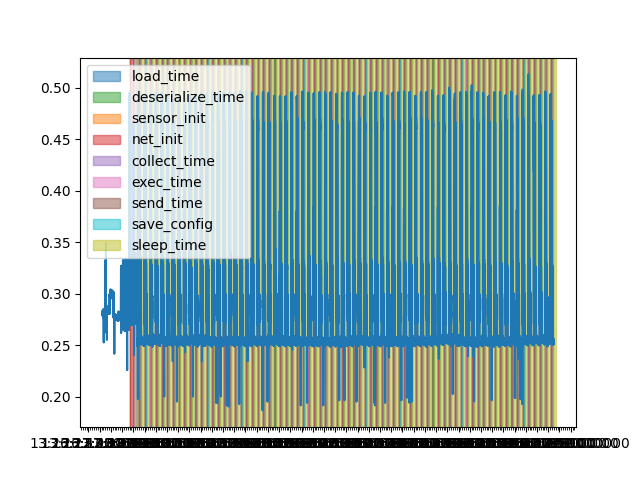

In [76]:
node_id = "70B3D57ED005EA70"
timing_data = loops[loops["node_id"] == node_id]
power_data = power_consumption[power_consumption["node_id"] == node_id]

plt.figure()
plt.plot(power_data.index, power_data["power"])
for row in timing_data.itertuples():
    plt.axvspan(row.load_start, row.load_end, color='tab:blue', alpha=0.5, label="load_time")
    plt.axvspan(row.deserialize_start, row.deserialize_end, color='tab:green', alpha=0.5, label="deserialize_time")
    plt.axvspan(row.sensor_init_start, row.sensor_init_end, color='tab:orange', alpha=0.5, label="sensor_init")
    plt.axvspan(row.net_init_start, row.net_init_end, color='tab:red', alpha=0.5, label="net_init")
    plt.axvspan(row.collect_time_start, row.collect_time_end, color='tab:purple', alpha=0.5, label="collect_time")
    plt.axvspan(row.exec_start, row.exec_end, color='tab:pink', alpha=0.5, label="exec_time")
    plt.axvspan(row.send_start, row.send_end, color='tab:brown', alpha=0.5, label="send_time")
    plt.axvspan(row.save_config_start, row.save_config_end, color='tab:cyan', alpha=0.5, label="save_config")
    plt.axvspan(row.sleep_start, row.sleep_end, color='tab:olive', alpha=0.5, label="sleep_time")
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))

plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels
plt.show()


## Add events if any

In [31]:
# get all relevant frame-events
%sql send_frame_start << select * from expdb.Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from expdb.Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from expdb.Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from expdb.Trace WHERE message LIKE '%received something%'

print(f"{len(send_frame_start)} send frame start events. {len(send_frame_end)} end events. {len(receive_frame_start)} receive frame start events. {len(receive_frame_end)} end events.")

Running query in 'duckdb'

Running query in 'duckdb'

Running query in 'duckdb'

Running query in 'duckdb'

0 send frame start events. 0 end events. 0 receive frame start events. 0 end events.


In [32]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

In [33]:
# add send and receive columns to plot
#TODO: update this to support more nodes
# for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
#     start_time = send_start_row.timestamp
#     end_time = send_end_row.timestamp
#     plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

# for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
#     start_time = receive_frame_start.timestamp
#     end_time = receive_frame_end.timestamp
#     plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()

In [34]:
%sql SELECT * from expdb.Content_Message

Running query in 'duckdb'

,content_message_id,frame_counter,frame_port,frame_payload
0,1,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
1,2,0,2,PDM=
2,3,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
3,4,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
4,5,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
...,...,...,...,...
231,247,73,2,CgA=
232,248,54,2,CgA=
233,249,74,2,CgA=
234,250,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...


In [35]:
%%sql
SELECT
    through_gateway,
    gateway_received_at,
    app_received_at,
    rssi,
    snr,
    bandwidth,
    frequency,
    consumed_airtime_s,
    spreading_factor,
    coding_rate,
    frame_counter,
    frame_port,
    frame_payload,
    from_base64(frame_payload) as decoded_payload,
    related_node,
    network_received_at
FROM
    expdb.Uplink_Message,
    expdb.Content_Message,
    expdb.Message 
WHERE
    Uplink_Message.uplink_message_id = Message.message_id AND
    Content_Message.content_message_id = Message.message_id

Running query in 'duckdb'

,through_gateway,gateway_received_at,app_received_at,rssi,snr,bandwidth,frequency,consumed_airtime_s,spreading_factor,coding_rate,frame_counter,frame_port,frame_payload,decoded_payload,related_node,network_received_at
0,iot-lab-saclay-gateway,2024-06-03 13:28:22,2024-06-03 13:28:23.002963,-23,2.00,125000,867700000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA70,2024-06-03 13:28:22.795312
1,gw-tetech-test,2024-06-03 13:28:39,2024-06-03 13:28:39.422544,-123,-10.80,125000,868100000,1.155072,SF12,4/5,1,2,CgA=,"[10, 0]",70B3D57ED005EA70,2024-06-03 13:28:39.213721
2,iot-lab-saclay-gateway,2024-06-03 13:29:01,2024-06-03 13:29:01.612184,-25,9.50,125000,868300000,1.155072,SF12,4/5,2,2,CgA=,"[10, 0]",70B3D57ED005EA70,2024-06-03 13:29:01.407136
3,gw-tetech-test,2024-06-03 13:29:07,2024-06-03 13:29:07.271463,-116,-0.50,125000,868300000,1.155072,SF12,4/5,1,2,PDM=,"[60, 51]",70B3D57ED005EA66,2024-06-03 13:29:07.064204
4,iot-lab-saclay-gateway,2024-06-03 13:29:09,2024-06-03 13:29:09.682457,-21,8.25,125000,868100000,1.155072,SF12,4/5,3,2,CgA=,"[10, 0]",70B3D57ED005EA70,2024-06-03 13:29:09.478295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,iot-lab-saclay-gateway,2024-06-03 13:45:55,2024-06-03 13:45:56.094255,-34,9.75,125000,868100000,1.155072,SF12,4/5,50,2,CgA=,"[10, 0]",70B3D57ED005EA73,2024-06-03 13:45:55.888558
163,gw-tetech-test,2024-06-03 13:46:00,2024-06-03 13:46:00.989200,-121,-7.20,125000,868100000,1.155072,SF12,4/5,70,2,CgA=,"[10, 0]",70B3D57ED005EA70,2024-06-03 13:46:00.778132
164,gw-tetech-test,2024-06-03 13:46:46,2024-06-03 13:46:46.286603,-122,-10.00,125000,868300000,1.155072,SF12,4/5,73,2,CgA=,"[10, 0]",70B3D57ED005EA70,2024-06-03 13:46:46.069252
165,gw-tetech-test,2024-06-03 13:36:07,2024-06-03 13:36:07.223829,-121,-10.50,125000,868300000,1.155072,SF12,4/5,11,2,CgA=,"[10, 0]",70B3D57ED005EA73,2024-06-03 13:36:07.012533


## experiment stats
with sync signals and events mapped we can see some stats on the experiments

In [36]:
%%sql
select * from expdb.Node

Running query in 'duckdb'

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
1,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
2,70B3D57ED005EA61,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
3,70B3D57ED005EA62,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
4,70B3D57ED005EA63,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
5,70B3D57ED005EA64,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
6,70B3D57ED005EA65,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
7,70B3D57ED005EA66,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
8,70B3D57ED005EA67,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
9,70B3D57ED005EA68,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0


In [37]:
loops.groupby('node_id')['loop_num'].max()

node_id
70B3D57ED005EA59    14
70B3D57ED005EA60    61
70B3D57ED005EA61    71
70B3D57ED005EA66    71
70B3D57ED005EA67    71
70B3D57ED005EA68    14
70B3D57ED005EA70    74
70B3D57ED005EA73    54
70B3D57ED005EA74    43
70B3D57ED005EA75    43
70B3D57ED005EA76    71
70B3D57ED005EA77    61
70B3D57ED005EA78    42
Name: loop_num, dtype: int64

## Calculate Total Energy Consumed per region

In [38]:
np.sum((np.abs(np.diff(power_consumption.index.to_numpy())) / np.timedelta64(1, 's')) * power_consumption["power"].values[:-1])

12833.69781302502

In [39]:
#define function to calculate energy consumed

def calc_energy_consumed(df: pd.DataFrame):

    # create a copy of the dataframe with only index and power
    if len(df) == 0:
        return 0
    #     # ensure we only calculate for data frames containing data from a single node
    # assert len(df["node_id"].unique()) == 1, "energy consumption only supported for single node"

    # # assert df have columns "power" and index of "timestamp" type
    # assert "power" in df.columns, "power column not found"
    # assert isinstance(df.index, pd.DatetimeIndex), "index is not  of type pd.DatetimeIndex"
    times = df.index.array
    powers = df["power"].values

    #power["power_diff"] = power.diff().shift(-1) #  current - previous, shifted one back so it becomes next - current. i.e. current + diff = next
    time_diff= np.abs(np.diff(times)) # abs(next-current)
    time_diff_s = time_diff / np.timedelta64(1, 's') # get timediff in fractions of a second
    powers = powers[:-1] # drop last row since it has no next and doesnt match up with the time_diff
    return np.sum(powers * time_diff_s) # returns the sum of power times fractions of a second. Since power is in W and time_diff_s is in seconds it is in W*s or J


In [40]:
# loops contain the start and end times of each activity, so loop over loops and calculate the energy for each activity
def calc_energy_consumed_per_activity(series_loops: pd.Series) -> pd.Series:
    power_consumption_for_node = power_consumption[(power_consumption["node_id"] == series_loops["node_id"])]
    return pd.Series({
        "node_id": series_loops["node_id"],
        "loop_num": series_loops["loop_num"],
        "total": calc_energy_consumed(power_consumption_for_node.loc[series_loops.name:series_loops["sleep_end"]]),
        "loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops.name:series_loops["loop_signal_end"]]),
        "total without loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops["loop_signal_end"]:series_loops["sleep_end"]]),
        "load config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["load_start"]:series_loops["load_end"]]),
        "deserialize": calc_energy_consumed(power_consumption_for_node.loc[series_loops["deserialize_start"]:series_loops["deserialize_end"]]),
        "sensor init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sensor_init_start"]:series_loops["sensor_init_end"]]),
        "net init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["net_init_start"]:series_loops["net_init_end"]]),
        "sensor collect": calc_energy_consumed(power_consumption_for_node.loc[series_loops["collect_time_start"]:series_loops["collect_time_end"]]),
        "query execution": calc_energy_consumed(power_consumption_for_node.loc[series_loops["exec_start"]:series_loops["exec_end"]]),
        "send": calc_energy_consumed(power_consumption_for_node.loc[series_loops["send_start"]:series_loops["send_end"]]),
        "save config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["save_config_start"]:series_loops["save_config_end"]]),
        "sleep": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sleep_start"]:series_loops["sleep_end"]]),
    })
energy_consumed = loops.apply(calc_energy_consumed_per_activity, axis=1)
energy_consumed_summary = energy_consumed.describe()
energy_consumed_summary

,loop_num,total,loop signal,total without loop signal,load config,deserialize,sensor init,net init,sensor collect,query execution,send,save config,sleep
count,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000
mean,30.257468,5.746691,0.310652,5.435720,0.005869,0.004583,0.006958,1.535771,0.029869,0.015939,0.806244,0.159752,2.867190
std,19.722519,16.263845,0.007283,16.263844,0.000185,0.008694,0.000219,16.225493,0.016510,0.013595,0.910858,0.012245,0.775131
min,0.000000,0.568627,0.284445,0.283312,0.005320,0.000285,0.006345,0.013931,0.020025,0.008047,0.000000,0.142178,0.082084
25%,13.000000,4.102322,0.309125,3.791838,0.005716,0.000332,0.006870,0.015260,0.022029,0.009511,0.000325,0.158107,2.083442
50%,29.000000,4.185987,0.311622,3.870345,0.005911,0.000651,0.006959,0.015517,0.022235,0.009670,0.000646,0.159616,3.186984
75%,45.000000,4.464731,0.314101,4.154647,0.005976,0.000670,0.007078,0.015682,0.022742,0.009830,1.909612,0.161045,3.577350
max,74.000000,260.036112,0.322062,259.723970,0.006281,0.023434,0.007490,255.408238,0.066008,0.045832,3.082599,0.373323,3.675925


In [41]:
import scipy.stats as st
import statsmodels.stats.api as smstats

def calc_confidence_interval(series: pd.Series) -> pd.Series:
    low, high = smstats.DescrStatsW(series).tconfint_mean(alpha=0.05)
    #low, high = st.norm.interval(0.95, loc=series["mean"], scale=series["std"])
    return pd.Series({
        "low": low,
        "high": high
    })



In [42]:
energy_consumed

,node_id,loop_num,total,loop signal,total without loop signal,load config,deserialize,sensor init,net init,sensor collect,query execution,send,save config,sleep
loop_signal_start,,,,,,,,,,,,,,
2024-06-03 13:28:08.640145,70B3D57ED005EA68,0,260.036112,0.311812,259.723970,0.005638,0.000663,0.007282,255.408238,0.022614,0.014821,3.046569,0.176953,1.037381
2024-06-03 13:28:09.238729,70B3D57ED005EA66,0,7.333013,0.312500,7.020185,0.005678,0.000669,0.006655,2.708788,0.022343,0.009693,3.053607,0.177710,1.031364
2024-06-03 13:28:09.849694,70B3D57ED005EA59,0,256.846360,0.309076,256.536965,0.005845,0.000322,0.007164,252.240551,0.022691,0.011173,3.047160,0.176767,1.021900
2024-06-03 13:28:11.016448,70B3D57ED005EA61,0,7.617037,0.310030,7.306677,0.005828,0.000649,0.006786,3.040974,0.021824,0.009733,3.022168,0.176178,1.019292
2024-06-03 13:28:11.176134,70B3D57ED005EA60,0,50.237644,0.320493,49.916811,0.006076,0.000338,0.007380,45.590644,0.022228,0.009555,3.069529,0.177817,1.029931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03 13:46:57.044150,70B3D57ED005EA76,71,2.428912,0.310356,2.118241,0.005969,0.000330,0.006965,0.015521,0.022156,0.009556,0.000338,0.160766,1.892991
2024-06-03 13:46:57.049026,70B3D57ED005EA67,71,2.480700,0.315197,2.165179,0.005719,0.000675,0.007077,0.015749,0.022833,0.009676,0.000336,0.164181,1.935235
2024-06-03 13:46:58.594921,70B3D57ED005EA70,74,2.371229,0.306867,2.064044,0.005938,0.023122,0.006624,0.015469,0.064371,0.044438,1.365438,0.157480,0.377220


In [43]:
error_bounds = energy_consumed[["total", "total without loop signal", "loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]].apply(calc_confidence_interval)


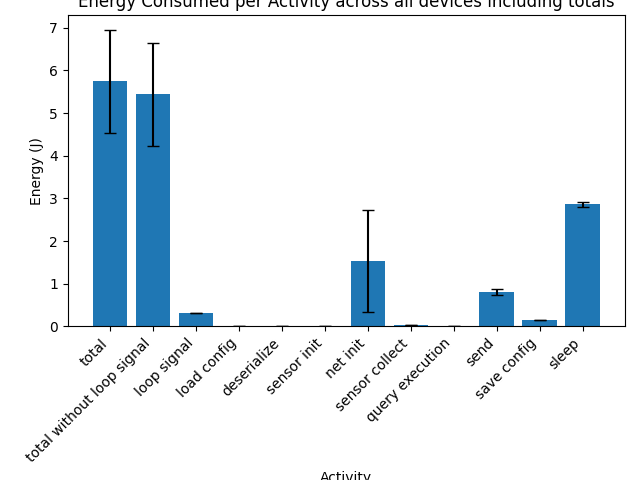

In [44]:
# plot barchart with stddev error bars
plt.figure()
to_plot = energy_consumed_summary[["total", "total without loop signal", "loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]

## since error_bounds are absolute and matplotlib likes them relative, we need to substract the mean to get relative error - and take the absolute to flip
## the sign on the lower bound
error_relative = np.abs(error_bounds - to_plot.loc["mean"])

plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=error_relative,capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices including totals")
plt.show()

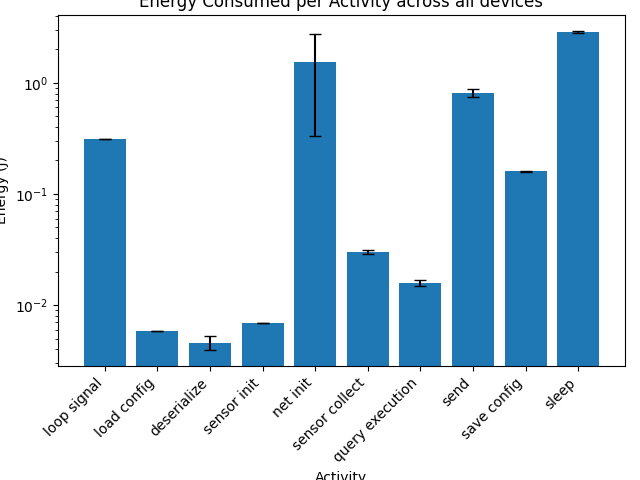

In [47]:
# plot barchart without totals 
plt.figure()
to_plot = energy_consumed_summary[["loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
error_relative = np.abs(error_bounds[["loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]] - to_plot.loc["mean"])
plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=error_relative, log=True, capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices")
plt.show()

In [48]:
# plot barchart without totals and without the 0th loop
# recalc summary without 0 loops
without_0th_loop = loops[loops["loop_num"] > 0].apply(calc_energy_consumed_per_activity, axis=1)
without_0th_loop_summary = without_0th_loop.describe()

In [49]:
error_bounds_without_0th_loop = without_0th_loop[["total", "total without loop signal", "loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]].apply(calc_confidence_interval)


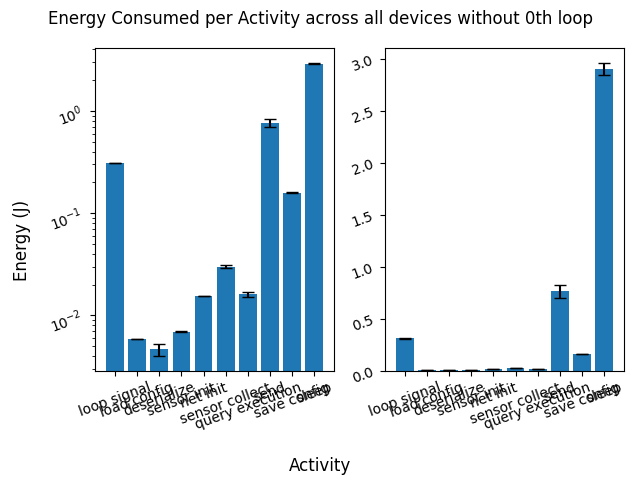

In [51]:
to_plot = without_0th_loop_summary[["loop signal", "load config","deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]

errors_relative = np.abs(error_bounds_without_0th_loop[["loop signal", "load config","deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]] - to_plot.loc["mean"])
#energy_consumed_without_0th_loop
## plot both with log scale and without
fig, (ax1, ax2) =  plt.subplots(1,2)

fig.suptitle("Energy Consumed per Activity across all devices without 0th loop")
fig.supxlabel("Activity")
fig.supylabel("Energy (J)")

ax1.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors_relative, capsize=4, log=True)
ax1.tick_params(labelrotation=20)

ax2.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors_relative, capsize=4)
ax2.tick_params(labelrotation=20)



plt.tight_layout()
plt.show()

In [52]:
without_0th_loop.groupby("node_id").describe()

loop_num                                                  \
                    count  mean        std  min    25%   50%    75%   max   
node_id                                                                     
70B3D57ED005EA59     14.0   7.5   4.183300  1.0   4.25   7.5  10.75  14.0   
70B3D57ED005EA60     61.0  31.0  17.752934  1.0  16.00  31.0  46.00  61.0   
70B3D57ED005EA61     71.0  36.0  20.639767  1.0  18.50  36.0  53.50  71.0   
70B3D57ED005EA66     71.0  36.0  20.639767  1.0  18.50  36.0  53.50  71.0   
70B3D57ED005EA67     71.0  36.0  20.639767  1.0  18.50  36.0  53.50  71.0   
70B3D57ED005EA68     14.0   7.5   4.183300  1.0   4.25   7.5  10.75  14.0   
70B3D57ED005EA70     74.0  37.5  21.505813  1.0  19.25  37.5  55.75  74.0   
70B3D57ED005EA73     54.0  27.5  15.732133  1.0  14.25  27.5  40.75  54.0   
70B3D57ED005EA74     43.0  22.0  12.556539  1.0  11.50  22.0  32.50  43.0   
70B3D57ED005EA75     43.0  22.0  12.556539  1.0  11.50  22.0  32.50  43.0   
70B3D57ED005EA76     71.0  36.0  20.639767  1.0  18.50  36.0  53.50  71.0   
70B3D57ED005EA77     61.0  31.0  17.752934  1.0  16.00  31.0  46.00  61.0   
70B3D57ED005EA78     42.0  21.5  12.267844  1.0  11.25  21.5  31.75  42.0   

                 total            ... save config           sleep            \
                 count      mean  ...         75%       max count      mean   
node_id                           ...                                         
70B3D57ED005EA59  14.0  4.230321  ...    0.159816  0.160867  14.0  3.144473   
70B3D57ED005EA60  61.0  4.314196  ...    0.162898  0.164917  61.0  3.124349   
70B3D57ED005EA61  71.0  4.217225  ...    0.159206  0.160371  71.0  3.051255   
70B3D57ED005EA66  71.0  4.240046  ...    0.160606  0.161390  71.0  3.077775   
70B3D57ED005EA67  71.0  4.292555  ...    0.164222  0.165020  71.0  3.110938   
70B3D57ED005EA68  14.0  4.276794  ...    0.161338  0.163003  14.0  3.180294   
70B3D57ED005EA70  74.0  4.256831  ...    0.158260  0.159356  74.0  2.259580   
70B3D57ED005EA73  54.0  4.334857  ...    0.161400  0.163453  54.0  2.305887   
70B3D57ED005EA74  43.0  4.241905  ...    0.160541  0.162702  43.0  3.056635   
70B3D57ED005EA75  43.0  3.720226  ...    0.144409  0.145039  43.0  2.659614   
70B3D57ED005EA76  71.0  4.208162  ...    0.160801  0.161985  71.0  3.048406   
70B3D57ED005EA77  61.0  4.197756  ...    0.157187  0.158185  61.0  3.040141   
70B3D57ED005EA78  42.0  4.220555  ...    0.159946  0.161818  42.0  3.043481   

                                                                              
                       std       min       25%       50%       75%       max  
node_id                                                                       
70B3D57ED005EA59  0.716981  2.042186  2.440199  3.572235  3.586153  3.596844  
70B3D57ED005EA60  0.736887  2.057717  2.087776  3.621741  3.640052  3.675925  
70B3D57ED005EA61  0.728940  1.981808  2.044110  3.558147  3.572115  3.592333  
70B3D57ED005EA66  0.724011  2.036606  2.062958  3.576618  3.595123  3.615898  
70B3D57ED005EA67  0.745629  1.935235  2.085336  3.634924  3.641253  3.652625  
70B3D57ED005EA68  0.724198  2.063383  2.470067  3.617917  3.625445  3.634061  
70B3D57ED005EA70  0.221862  0.377220  2.282242  2.283637  2.286512  2.299652  
70B3D57ED005EA73  0.088882  1.673740  2.305006  2.317560  2.330428  2.348562  
70B3D57ED005EA74  0.862181  0.150722  2.097156  3.632525  3.647935  3.663903  
70B3D57ED005EA75  0.756536  0.082084  1.818388  3.161113  3.183042  3.191393  
70B3D57ED005EA76  0.731325  1.892991  2.041722  3.561640  3.567038  3.591145  
70B3D57ED005EA77  0.715891  2.017079  2.025986  3.533713  3.535107  3.552287  
70B3D57ED005EA78  0.724136  2.014330  2.040581  3.538618  3.555829  3.570714  

[13 rows x 104 columns]

In [107]:
## plot per node
grouped = without_0th_loop[["node_id","loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]] \
    .groupby("node_id")
# grouped_agg = grouped.agg(["mean", "std"])
# def hej(row: pd.Series):
#     outermost_column = list(set(k[0] for k in row.keys()))
#     idx = pd.MultiIndex.from_product([outermost_column, ["low","high"]])
#     res = pd.Series(index=idx)
#     for col in outermost_column:
#         res[col] = calc_confidence_interval(row[col])
#     return res
# ci = grouped_agg.apply(hej, axis=1)

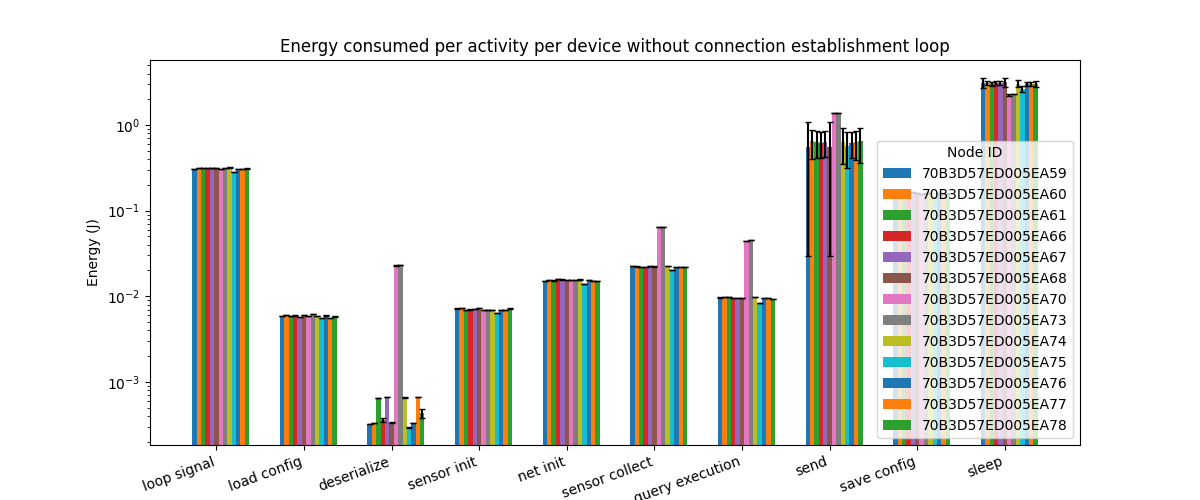

In [109]:
columns = ["loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]
locations = np.arange(len(columns))
width = 0.05
multiplier = 0
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for node_id, row in grouped:
    values = row[columns].mean().values
    error_bounds = row[columns].apply(calc_confidence_interval)
    errors_relative = np.abs(error_bounds - values)
    #values = row.loc[node_id,(slice(None),"mean")][["loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]].values
    #errors_low = values - ci.loc[node_id,(slice(None),"low")][["loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
    #errors_high = ci.loc[node_id,(slice(None),"high")][["loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]] - values
    # for node_id, mean in row.loc[activity,"mean"].items():
    offset = width * multiplier

    rects = ax.bar(locations + offset, values, width, capsize=2, label=node_id, yerr=errors_relative, log=True)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.legend(title="Node ID")
ax.set_title("Energy consumed per activity per device without connection establishment loop")
ax.set_ylabel("Energy (J)")
ax.set_xlabel("Activity")
ax.set_xticks(locations + 0.25, columns, rotation=20, ha="right")
plt.show()

In [78]:
import gc
gc.collect()

0

In [ ]:

#TODO: vis distribution over query execution means
# IFT: 2 modaliteter: selectivity på filtre. lav exp med forskl. selectivity og regression til cost model
# størrelse af query: save cost afhænger af query størrelse

# TODO: from Viktor
# before doing the above try to from the data you have derive a power consumption per time period and estimate the powerconsumption linearly based on the time the activity takes
# regarding outliars in the total plot. Remove them. 
